In [1]:
import argparse
import pathlib
import random
from collections import deque
from typing import List, Dict, Tuple, Union
from data import Dataset, SuperclassDataset
from data_utils import *
from sampling import *
from models import BetaBernoulli
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from utils import mean_reciprocal_rank
%matplotlib inline  

import matplotlib;matplotlib.rcParams['font.size'] = 10
import matplotlib;matplotlib.rcParams['font.family'] = 'serif'
LINEWIDTH = 13.97

LOG_FREQ = 10
RUNS = 100
method_list = ['random_arm', 'random_data', 'random_arm_informed', 'random_data_informed', 'ts_uniform', 'ts_informed']
method_format = {'random_arm': ('Random Arm', 'b', '.', '-'), 
                 'random_data': ('Random Datapoint', 'g', '^', '-'), 
                 'random_arm_informed': ('Random Arm Informed', 'b', '.', '--'), 
                 'random_data_informed': ('Random Datapoint Informed', 'g', '^', '--'), 
                 'ts_uniform': ('TS Symmetric', 'k', '*', '-'), 
                 'ts_informed': ('TS Informed', 'r', '+', '-'),
                }
DATASET_LIST = ['cifar100', 'svhn', '20newsgroup', 'dbpedia'] #'imagenet', 
output_dir = pathlib.Path("../output/confusion_matrix")

In [2]:
metric = 'confusion_matrix' # 'ece', 'confusion_matrix'
group_method = 'predicted_class'
pseudocount = 1
RUNS = 100
superclass = False #todo: superclass=true
cost_matrix = None
topk = 1

In [5]:
# load results and compute ground truth
ground_truth = {}
weight_k = {}
l2_error = {}
logp = {} # log likelihood of each estimated confusion matrix under dirichlet distribution

for dataset_name in DATASET_LIST: # takes 4 minutes to load results of imagenet
    ground_truth[dataset_name] = {}
    l2_error[dataset_name] = {}
    logp[dataset_name] = {}
    
    # load data
    if len(dataset_name) > len('superclass') and dataset_name[-len('superclass'):] == 'superclass':
        superclass = True
    else:
        superclass = False
    
    print(dataset_name, superclass)
    experiment_name = '%s_top%d_pseudocount%d' % (dataset_name, topk, pseudocount)
    if superclass:
        dataset = SuperclassDataset.load_from_text(dataset_name.split('_')[0], CIFAR100_SUPERCLASS_LOOKUP)
        # no need to group (grouped by superclass automatically)
    else:
        dataset = Dataset.load_from_text(dataset_name)
        dataset.group(group_method = group_method)
    # ground truth
    weight_k[dataset_name] = dataset.weight_k
    confusion_probs = dataset.confusion_probs()
    confusion_probs = confusion_probs + np.ones(confusion_probs.shape) * 1e-6
    confusion_probs = confusion_probs / confusion_probs.sum(axis=1)
    ground_truth[dataset_name]['confusion_matrix'] = confusion_probs
    ground_truth[dataset_name]['confusion_matrix'] = \
        np.load(open(output_dir / experiment_name / ('mpe_log_%s_run%d.npy' % ('ts_uniform', 0)), 'rb'))[-1]
     # initalize l2 error
    for method_name in method_list:
        l2_error[dataset_name][method_name] = np.zeros((RUNS, dataset.__len__() // LOG_FREQ))
        logp[dataset_name][method_name] = np.zeros((RUNS, dataset.__len__() // LOG_FREQ))
        # load results
        for r in range(RUNS):
            mpe_log = np.load(open(output_dir / experiment_name / ('mpe_log_%s_run%d.npy' % (method_name, r)), 'rb'))            
            l2_eval = mpe_log - ground_truth[dataset_name]['confusion_matrix']
            l2_eval = l2_eval ** 2
            l2_eval = np.sum(l2_eval,axis=2)
            l2_error[dataset_name][method_name][r] = np.array([(l2_eval[i] * weight_k[dataset_name]).sum()
                                                               for i in range(dataset.__len__() // LOG_FREQ)])
    # baseline
    print('sss')
    mpe_diag = np.identity(dataset.num_groups)
    l2_eval = mpe_diag - ground_truth[dataset_name]['confusion_matrix']
    l2_eval = l2_eval ** 2
    l2_eval = np.sum(l2_eval,axis=1)
    l2_error[dataset_name]['diagonal'] = np.array((l2_eval * weight_k[dataset_name]).sum())

    mpe_ones = np.ones((dataset.num_groups,dataset.num_groups))
    mpe_ones /= dataset.num_groups
    l2_eval = mpe_ones - ground_truth[dataset_name]['confusion_matrix']
    l2_eval = l2_eval ** 2
    l2_eval = np.sum(l2_eval,axis=1)
    l2_error[dataset_name]['ones'] = np.array((l2_eval * weight_k[dataset_name]).sum())

    mpe_scores = confusion_probs
    l2_eval = mpe_scores - ground_truth[dataset_name]['confusion_matrix']
    l2_eval = l2_eval ** 2
    l2_eval = np.sum(l2_eval,axis=1)
    l2_error[dataset_name]['scores'] = np.array((l2_eval * weight_k[dataset_name]).sum())
    

cifar100 False
sss
svhn False
sss
20newsgroup False
sss
dbpedia False
sss


# $L_2$

Text(0, 0.5, '$L_2$ Error')

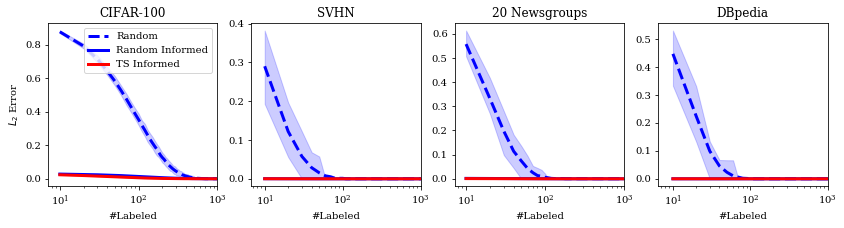

In [6]:
# plot
method_format = {#'random_arm': ('Random Arm', 'g', '.', '--'), 
                 'random_data': ('Random', 'b', '^', '--'), 
                 #'random_arm_informed': ('Random Arm Informed', 'g', '.', '-'), 
                 'random_data_informed': ('Random Informed', 'b', '^', '-'), 
                 #'ts_uniform': ('TS Symmetric', 'k', '*', '-'), 
                 'ts_informed': ('TS Informed', 'r', '+', '-'),}


fig, axes = plt.subplots(nrows=1, ncols=len(DATASET_LIST), figsize=(LINEWIDTH,3),
                        gridspec_kw = {'wspace':0.2, 'hspace':0.25})
for i, dataset_name in enumerate(DATASET_LIST):
    start = 0
    num_steps = l2_error[dataset_name][method_name].shape[1] - 1
    stepsize = 1
    for method_name in method_format:
        legend_name, color, marker, linestyle = method_format[method_name]    
        xrange = np.arange(num_steps) * LOG_FREQ + LOG_FREQ
        idx = np.arange(num_steps)[start:(start+num_steps)][::stepsize]   
        axes[i].plot(xrange[idx], 
                 np.mean((l2_error[dataset_name][method_name]), axis=0)[idx], 
                 label=legend_name, linewidth=3, color=color, linestyle=linestyle)
        axes[i].fill_between(xrange[idx], 
                         np.quantile(l2_error[dataset_name][method_name], 0.125, axis=0)[idx], 
                         np.quantile(l2_error[dataset_name][method_name], 0.875, axis=0)[idx], 
                         color=color, alpha=.2)
        #plt.ylim([0, 0.3])
    axes[i].set_xlabel('#Labeled')
    axes[i].set_xscale('log')
    axes[i].set_title(DATASET_NAMES[dataset_name])
    axes[i].set_xlim(0,1000)
    #axes[i].set_ylim(0,np.max(np.mean((l2_error[dataset_name]['random_data_informed']), axis=0)))
axes[0].legend(fontsize=10, loc='upper right')
axes[0].set_ylabel('$L_2$ Error')

In [7]:
method_format = {'random_data': ('Random', 'b', '^', '--'), 
                 'random_data_informed': ('Random Informed', 'b', '^', '-'), 
                 'ts_informed': ('TS Informed', 'r', '+', '-'),}
for i, dataset_name in enumerate(DATASET_LIST):
    print('\n',dataset_name)
    dataset = Dataset.load_from_text(dataset_name)
    dataset.group(group_method = group_method)
    num_params = dataset.num_groups ^ 2
    N_list = [20,50,100]
    for N in N_list:
        N = max(int(N//10)*10, 10)
        print("N, #params=(%d,%d) =======" % (N,num_params))
        for method_name in method_format:
            print('%s: %.4f' % (method_name, l2_error[dataset_name][method_name][:, (N-LOG_FREQ)//LOG_FREQ].mean() / \
                 l2_error[dataset_name]['scores']))


 cifar100
N, #params=(20,102) =======
random_data: 9.1531
random_data_informed: 0.2992
ts_informed: 0.2229
N, #params=(50,102) =======
random_data: 6.7294
random_data_informed: 0.2376
ts_informed: 0.1296
N, #params=(100,102) =======
random_data: 4.0783
random_data_informed: 0.1614
ts_informed: 0.0667

 svhn
N, #params=(20,8) =======
random_data: 92.8235
random_data_informed: 0.1002
ts_informed: 0.0448
N, #params=(50,8) =======
random_data: 11.7515
random_data_informed: 0.0222
ts_informed: 0.0096
N, #params=(100,8) =======
random_data: 0.9460
random_data_informed: 0.0046
ts_informed: 0.0024

 20newsgroup
N, #params=(20,22) =======
random_data: 9.9370
random_data_informed: 0.0351
ts_informed: 0.0129
N, #params=(50,22) =======
random_data: 2.2086
random_data_informed: 0.0135
ts_informed: 0.0033
N, #params=(100,22) =======
random_data: 0.1885
random_data_informed: 0.0037
ts_informed: 0.0008

 dbpedia
N, #params=(20,12) =======
random_data: 1386.8522
random_data_informed: 0.1487
ts_informe

In [8]:
dataset_print= {
    'cifar100': 'CIFAR-100',
    'svhn': 'SVHN',
    '20newsgroup': '20 Newsgroups',
    'dbpedia': 'DBpedia'
}
dataset_list = ['cifar100','svhn', '20newsgroup','dbpedia']
method_format = {'random_data': ('Random', 'b', '^', '--'), 
                 'random_data_informed': ('Random Informed', 'b', '^', '-'), 
                 'ts_informed': ('TS Informed', 'r', '+', '-'),}
Nlist = [10,100,500];

print('\\begin{tabular}{@{}ccccccccccccccccc@{}}')
print('\\toprule ')
for dataset in dataset_list:
    print('& \phantom{a} &  \multicolumn{3}{c}{%s}' % dataset_print[dataset])
print('\\\ ')
for dataset in dataset_list:
    print('& \phantom{a} &  N=%d & N=%d & N=%d' % tuple(Nlist))
print('\\\ ')
print('\cmidrule{3-5} \cmidrule{7-9} \cmidrule{11-13} \cmidrule{15-17}')

for method in method_format:
    method_name = method_format[method][0]
    print('\multicolumn{2}{c}{%15s}' % method_name, end = '')
    
    for dataset_name in dataset_list:
        for N in N_list:
            val = l2_error[dataset_name][method][:, (N-LOG_FREQ)//LOG_FREQ].mean() / \
                        l2_error[dataset_name]['scores']
            print('& %4.1f  ' % (100 * val), end = '')
            
        if dataset_name != dataset_list[-1]:
            print('&', end = '')
    print('\\\\ \n', end = '');
print('\\bottomrule')
print('\\end{tabular}')

\begin{tabular}{@{}ccccccccccccccccc@{}}
\toprule 
& \phantom{a} &  \multicolumn{3}{c}{CIFAR-100}
& \phantom{a} &  \multicolumn{3}{c}{SVHN}
& \phantom{a} &  \multicolumn{3}{c}{20 Newsgroups}
& \phantom{a} &  \multicolumn{3}{c}{DBpedia}
\\ 
& \phantom{a} &  N=10 & N=100 & N=500
& \phantom{a} &  N=10 & N=100 & N=500
& \phantom{a} &  N=10 & N=100 & N=500
& \phantom{a} &  N=10 & N=100 & N=500
\\ 
\cmidrule{3-5} \cmidrule{7-9} \cmidrule{11-13} \cmidrule{15-17}
\multicolumn{2}{c}{         Random}& 915.3  & 672.9  & 407.8  && 9282.3  & 1175.2  & 94.6  && 993.7  & 220.9  & 18.8  && 138685.2  & 14376.7  & 410.0  \\ 
\multicolumn{2}{c}{Random Informed}& 29.9  & 23.8  & 16.1  && 10.0  &  2.2  &  0.5  &&  3.5  &  1.4  &  0.4  && 14.9  &  3.9  &  0.8  \\ 
\multicolumn{2}{c}{    TS Informed}& 22.3  & 13.0  &  6.7  &&  4.5  &  1.0  &  0.2  &&  1.3  &  0.3  &  0.1  &&  2.5  &  0.6  &  0.1  \\ 
\bottomrule
\end{tabular}


In [39]:
dataset_print= {
    'cifar100': 'CIFAR-100',
    'svhn': 'SVHN',
    '20newsgroup': '20 Newsgroups',
    'dbpedia': 'DBpedia'
}
dataset_list = ['cifar100','svhn']
#dataset_list = ['20newsgroup','dbpedia']
method_format = {'random_data': ('Random Uninformative', 'b', '^', '--'), 
                 'random_data_informed': ('Random Informative', 'b', '^', '-'), 
                 'ts_informed': ('TS Informative', 'r', '+', '-'),}
N_list = [20, 50, 100];

print('\\begin{tabular}{@{}ccccccccc@{}}')
print('\\toprule ')
for dataset in dataset_list:
    print('& \phantom{a} &  \multicolumn{3}{c}{%s}' % dataset_print[dataset])
print('\\\ ')
print('\cmidrule{3-5} \cmidrule{7-9}')
for dataset in dataset_list:
    print('& \phantom{a} &  N=%d & N=%d & N=%d' % tuple(Nlist))
print('\\\ \\midrule')

for method in method_format:
    method_name = method_format[method][0]
    print('\multicolumn{2}{c}{%20s}' % method_name, end = '')
    
    for dataset_name in dataset_list:
        y = l2_error[dataset_name][method]/l2_error[dataset_name]['scores']
        y = np.mean(y, axis=0)        
        for N in N_list:
            val = y[(N-LOG_FREQ)//LOG_FREQ]
            print('& %.3f  ' % val, end = '')
            
        if dataset_name != dataset_list[-1]:
            print('&', end = '')
    print('\\\\ \n', end = '');
print('\\bottomrule')
print('\\end{tabular}')

\begin{tabular}{@{}ccccccccc@{}}
\toprule 
& \phantom{a} &  \multicolumn{3}{c}{CIFAR-100}
& \phantom{a} &  \multicolumn{3}{c}{SVHN}
\\ 
\cmidrule{3-5} \cmidrule{7-9}
& \phantom{a} &  N=10 & N=100 & N=500
& \phantom{a} &  N=10 & N=100 & N=500
\\ \midrule
\multicolumn{2}{c}{Random Uninformative}& 9.153  & 6.729  & 4.078  && 92.823  & 11.752  & 0.946  \\ 
\multicolumn{2}{c}{  Random Informative}& 0.299  & 0.238  & 0.161  && 0.100  & 0.022  & 0.005  \\ 
\multicolumn{2}{c}{      TS Informative}& 0.223  & 0.130  & 0.067  && 0.045  & 0.010  & 0.002  \\ 
\bottomrule
\end{tabular}


In [42]:
num_groups_dict = {}
for dataset in DATASET_LIST:
    if group_method == 'score_equal_size':
        num_groups_dict[dataset] = 10
    if group_method == 'predicted_class':
        num_groups_dict[dataset] = NUM_CLASSES_DICT[dataset]

In [56]:
def print_narrow_table(dataset_list):
    
    N_list = [2, 5, 8]
    method_format = {'random_data': ('UPrior', 'b', '^', '--'), 
                     #'ts_uniform': ('UPrior+TS', 'b', '^', '--'), 
                     'random_data_informed': ('IPrior', 'b', '^', '-'), 
                     'ts_informed': ('IPrior+TS', 'r', '+', '-'),}
    print('\\begin{tabular}{@{}ccccccc@{}}')
    print('\\toprule ')
    print('{N/K} & {N}', end = '')
    for method in method_format:
        print('& {%10s}' % method_format[method][0], end = '')
    print('\\\ ')
    
    for i, dataset_name in enumerate(dataset_list):
        print('\\midrule')
        for idx, N in enumerate(N_list):
            if idx == 0:
                name_string = DATASET_NAMES[dataset_name]
            else:
                name_string = ''
            vals = []
            for method in method_format:
                y = l2_error[dataset_name][method]/l2_error[dataset_name]['scores']
                y = np.mean(y, axis=0) 
                K = num_groups_dict[dataset_name]
                num_samples = int(N*K)
                vals.append(y[(num_samples-LOG_FREQ)//LOG_FREQ])
            print('{%20s} & %d & %d & %.3f &%.3f &\\textbf{%.3f} \\\\ \n' % \
                  (name_string, N, num_samples, vals[0], vals[1], vals[2]), end = '')
    print('\\bottomrule')
    print('\\end{tabular}')

print_narrow_table(DATASET_LIST)

\begin{tabular}{@{}ccccccc@{}}
\toprule 
{N/K} & {N}& {    UPrior}& {    IPrior}& { IPrior+TS}\\ 
\midrule
{           CIFAR-100} & 2 & 200 & 1.463 &0.077 &\textbf{0.025} \\ 
{                    } & 5 & 500 & 0.071 &0.012 &\textbf{0.004} \\ 
{                    } & 8 & 800 & 0.001 &0.003 &\textbf{0.001} \\ 
\midrule
{                SVHN} & 2 & 20 & 92.823 &0.100 &\textbf{0.045} \\ 
{                    } & 5 & 50 & 11.752 &0.022 &\textbf{0.010} \\ 
{                    } & 8 & 80 & 0.946 &0.008 &\textbf{0.004} \\ 
\midrule
{       20 Newsgroups} & 2 & 40 & 3.405 &0.018 &\textbf{0.005} \\ 
{                    } & 5 & 100 & 0.188 &0.004 &\textbf{0.001} \\ 
{                    } & 8 & 160 & 0.036 &0.001 &\textbf{0.000} \\ 
\midrule
{             DBpedia} & 2 & 28 & 1386.852 &0.149 &\textbf{0.025} \\ 
{                    } & 5 & 70 & 36.962 &0.018 &\textbf{0.003} \\ 
{                    } & 8 & 112 & 0.000 &0.006 &\textbf{0.001} \\ 
\bottomrule
\end{tabular}


In [37]:
print(y)

[0.10486084 0.04479261 0.02359379 ... 0.00010999 0.00011    0.00011   ]


In [ ]:
for method in method_format:
    method_name = method_format[method][0]
    for dataset_name in dataset_list:
        y = l2_error[dataset_name][method]/l2_error[dataset_name]['scores']
        y = np.mean(y, axis=0)        
        for N in N_list:
            val = y[(N-LOG_FREQ)//LOG_FREQ]
            print('====', method, dataset_name, (N-LOG_FREQ)//LOG_FREQ, val)
        print(y.max())

In [ ]:
# plot
method_format = {#'random_arm': ('Random Arm', 'g', '.', '--'), 
                 #'random_data': ('Random', 'b', '^', '--'), 
                 #'random_arm_informed': ('Random Arm Informed', 'g', '.', '-'), 
                 'random_data_informed': ('Random Informative', 'b', '^', '-'), 
                 #'ts_uniform': ('TS Symmetric', 'k', '*', '-'), 
                 'ts_informed': ('TS Informative', 'r', '+', '-'),}


fig, axes = plt.subplots(nrows=1, ncols=len(DATASET_LIST), figsize=(LINEWIDTH,2.2),
                        gridspec_kw = {'wspace':0.2, 'hspace':0.25})
for i, dataset_name in enumerate(DATASET_LIST):
    start = 0
    num_steps = l2_error[dataset_name]['ts_informed'].shape[1] - 1
    stepsize = 1
    for method_name in method_format:
        legend_name, color, marker, linestyle = method_format[method_name]    
        xrange = np.arange(num_steps) * LOG_FREQ + LOG_FREQ
        idx = np.arange(num_steps)[start:(start+num_steps)][::stepsize]  
        y = l2_error[dataset_name][method_name]/ l2_error[dataset_name]['scores']
        eval_mean = np.mean(y, axis=0)
        eval_upper = np.quantile(y, 0.875, axis=0)
        eval_lower = np.quantile(y, 0.125, axis=0)
        axes[i].plot(xrange[idx], 
                 eval_mean[idx], 
                 label=legend_name, linewidth=3, color=color, linestyle=linestyle)
        axes[i].fill_between(xrange[idx], 
                         eval_lower[idx], 
                         eval_upper[idx], 
                         color=color, alpha=.2)
        #plt.ylim([0, 0.3])
    axes[i].set_xlabel('#Labeled')
    axes[i].set_xscale('log')
    #axes[i].set_yscale('log')
    axes[i].set_title(DATASET_NAMES[dataset_name])
axes[0].legend(fontsize=10, loc='upper right')
axes[0].set_ylabel('$L_2$ Error')

In [ ]:
l2_error[dataset_name]['diagonal'], l2_error[dataset_name]['ones']